<a href="https://colab.research.google.com/github/dmika1234/dl_uwr/blob/develop/Assignments/Assignment4/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assigment 4

**Submission deadlines**:

* get at least 4 points by 17.05.2023
* remaining points: last lab session before or on 26.05.2023

**Points:** Aim to get 12 out of 15+ possible points

All needed data files should be on Drive: <https://drive.google.com/drive/folders/1HaMbhzaBxxNa_z_QJXSDCbv5VddmhVVZ?usp=sharing> 

In [1]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
# Huggingface Transformers implementation
!pip install -q tqdm boto3 requests regex sentencepiece sacremoses
!pip install -q transformers


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
%matplotlib inline

In [8]:
import collections

import codecs

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import distance

import nltk
import sklearn
# nltk.download('punkt')

import pandas as pd
import pprint
import gensim

import io
from tqdm.autonotebook import tqdm


import torch


import tabulate

## Task 1 (5 points)

Implement simplified word2vec with negative sampling from scratch (using pure numpy). Assume that in the training data objects and contexts are given explicitly, one pair per line, and objects are on the left. The result of the training should be object vectors. Please, write them to a file using *natural* text format, ie

<pre>
word1 x1_1 x1_2 ... x1_N 
word2 x2_1 x2_2 ... x2_N
...
wordK xK_1 xK_2 ... xk_N
</pre>

Use the loss from Slide 25 in Lecture NLP.01, compute the gradient manually. You can use some gradient clipping, or regularisation. 

**Remark**: the data is specially prepared to make the learning process easier. 
Present vectors using the code below. In this task we define success as 'obtaining a result which looks definitely not random'

In [6]:
!gdown "https://drive.google.com/uc?id=1a6Rki9MJwxq8m6HdqgMoS_iSLIGXIlia&export=download" -O DATA/task1_objects_contexts_polish.txt.gz
!gzip -dkf DATA/task1_objects_contexts_polish.txt.gz

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1a6Rki9MJwxq8m6HdqgMoS_iSLIGXIlia&export=download 

'gzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# with open("DATA/task1_objects_contexts_polish.txt", "r") as f:
#     lines = f.readlines()
# data = np.array([np.array(spair.strip().split()) for spair in lines])

In [52]:
data = pd.read_csv("DATA/task1_objects_contexts_polish.txt", sep=" ", header=None)
data.columns = ["word", "context"]
data['context'] = data['context'].str.split('_', expand=True).iloc[:, 1]
data.shape[0]

5525116

In [53]:
def preprocess_data(df):
    vocab = pd.concat([data['word'], data['context']]).unique()
    word_to_id = dict(zip(vocab, np.arange(vocab.shape[0])))
    id_to_word = dict(zip(word_to_id.values(), word_to_id.keys()))
    words_ids = np.array(df['word'].map(word_to_id)).reshape(-1,1)
    context_ids = np.array(df['context'].map(word_to_id)).reshape(-1,1)
    data_pairs = np.concatenate((words_ids, context_ids), axis=1)
    return word_to_id, id_to_word, data_pairs

In [81]:
class SimpleWord2Vec:
    def __init__(self, vocab_size, embed_size) -> None:
        # Initialize the weight matrices
        # W is the input word matrix
        # V is the output word matrix
        self.W = np.random.uniform(-0.8, 0.8, (vocab_size, embed_size))
        self.V = np.random.uniform(-0.8, 0.8, (vocab_size, embed_size))
        self.vocab_size = vocab_size
        self.embed_size = embed_size

    def train(self, pairs, lr=0.01, num_epochs=10, K=5):


        for epoch in range(num_epochs):
            epoch_loss = 0
            for w, c in pairs:
                # Positive sample
                y_pos = np.dot(self.W[w], self.V[c])
                loss_pos = -np.log(self.sigmoid(y_pos))

                # Negative samples
                neg_samples = np.random.choice(range(self.vocab_size), K)
                y_neg = np.dot(self.W[w], self.V[neg_samples].T)
                loss_neg = -np.sum(np.log(self.sigmoid(-y_neg)))

                # Total loss
                loss = loss_pos + loss_neg
                epoch_loss += loss

                # Gradients
                grad_w = (self.sigmoid(y_pos) - 1) * self.V[c] + np.sum(self.sigmoid(y_neg) * self.V[neg_samples].T, axis=1)
                grad_v_pos = (self.sigmoid(y_pos) - 1) * self.W[w]
                grad_v_neg = np.outer(self.sigmoid(y_neg), self.W[w])

                # Update weights
                self.W[w] -= lr * grad_w
                self.V[c] -= lr * grad_v_pos
                self.V[neg_samples] -= lr * grad_v_neg

            print(f"Epoch: {epoch+1}, Loss: {epoch_loss}")
        self.word_embeddings = self.W
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [55]:
word_to_id, id_to_word, data_pairs = preprocess_data(data)

In [82]:
# Hyperparameters
vocab_size = len(word_to_id.keys())  # Size of your vocabulary
embed_size = 300  # Size of the word embedding vectors
lr = 0.01  # Learning rate
num_epochs = 5  # Number of training epochs
K = 5  # Number of negative samples
model = SimpleWord2Vec(vocab_size, embed_size)

In [83]:
model.train(data_pairs, lr, num_epochs, K)
word_embeddings = model.word_embeddings

KeyboardInterrupt: 

In [88]:
with open("DATA/word_embeddings.npy", 'wb') as f:
    np.save(f, word_embeddings)

In [ ]:
from gensim.models import KeyedVectors
task1_wv = KeyedVectors.load_word2vec_format('task1_w2v_vectors.txt', binary=False)

example_english_words = ['dog', 'dragon', 'love', 'bicycle', 'marathon', 'logic', 'butterfly']  # replace, or add your own examples
example_polish_words = ['pies', 'smok', 'miłość', 'rower', 'maraton', 'logika', 'motyl']

example_words = example_polish_words

for w0 in example_words:
    print ('WORD:', w)
    for w, v in task1_wv.most_similar(w0):
        print ('   ', w, v)
    print()

## Task 2 (4 points)

Your task is to train the embeddings for Simple Wikipedia titles, using gensim library. As the example below shows, training is really simple:

```python
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")
```
*sentences* can be a list of list of tokens, you can also use *gensim.models.word2vec.LineSentence(source)* to create restartable iterator from file. At first, use [this file] containing such pairs of titles, that one article links to another.

We say that two titles are *related* if they both contain a word (or a word bigram) which is not very popular (it occurs only in several titles). Make this definition more precise, and create the corpora which contains pairs of related titles. Make a mixture of the original corpora, and the new one, then train title vectors again.

Compare these two approaches using similar code to the code from Task 1.

In [146]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from collections import defaultdict
from gensim.models.phrases import Phrases, Phraser

In [147]:
sentences = LineSentence("DATA/simple.wiki.links.txt")

In [149]:
model_titles_w2v = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)
model_titles_w2v.save("DATA/model_titles_w2v.model")

In [154]:
example_titles = ['george_jonas', 'israel']

for w0 in example_titles:
    print ('TITLE:', w0)
    for w, v in model_titles_w2v.wv.most_similar(w0):
        print ('   ', w, v)
    print()

TITLE: george_jonas
    cathy_ubels-veen 0.9927036166191101
    jørgen_ingmann 0.9925721883773804
    tom_graveney 0.992429792881012
    andrej_babiš 0.991958498954773
    manx_people 0.991751492023468
    eddie_lebaron 0.9917319416999817
    ivan_silayev 0.9917289614677429
    david_goodall_(botanist) 0.9916769862174988
    adrienne_clarkson 0.9915967583656311
    elizabeth_dawn 0.9915851950645447

TITLE: israel
    hong_kong 0.9748069643974304
    ukraine 0.974117636680603
    belarus 0.9668518900871277
    venezuela 0.9645896553993225
    bulgaria 0.9612427949905396
    iraq 0.960568368434906
    lithuania 0.9591671824455261
    kazakhstan 0.9591059684753418
    egypt 0.957570493221283
    thailand 0.9564592838287354



In [ ]:
word_freq = defaultdict(int)
for sentence in sentences:
    for word in sentence:
        word_freq[word] += 1

threshold = 10
unpopular_words = [word for word, freq in word_freq.items() if freq <= threshold]

related_sentences = []
for sentence in sentences:
    if any(word in sentence for word in unpopular_words):
        related_sentences.append(sentence)


In [ ]:
mixed_sentences = sentences + related_sentences
model_mixed_titles_w2v = Word2Vec(sentences=mixed_sentences, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
example_titles = ['george_jonas', 'israel']

for w0 in example_titles:
    print ('TITLE:', w0)
    for w, v in model_titles_w2v.wv.most_similar(w0):
        print ('   ', w, v)
    print()

# Task 3 (4 points)

Suppose that we have two languages: Upper and Lower. This is an example Upper sentence:

<pre>
THE QUICK BROWN FOX JUMPS OVER THE LAZY DOG.
</pre>

And this is its translation into Lower:

<pre>
the quick brown fox jumps over the lazy dog
</pre>

You have two corpora for these languages (with different sentences). Your task is to train word embedings for both languages together, so as to make embeddings of the words which are its translations as close as possible. But unfortunately, you have the budget which allows you to prepare the translation only for 1000 words (we call it D, you have to deside which words you want to be in D)

Prepare the corpora wich contains three kind of sentences:
* Upper corpus sentences
* Lower corpus sentences
* sentences derived from Upper/Lower corpus, modified using D

There are many possible ways of doing this, for instance this one (ROT13.COM: hfr rirel fragrapr sebz obgu pbecben gjvpr: jvgubhg nal zbqvsvpngvbaf, naq jvgu rirel jbeqf sebz Q ercynprq ol vgf genafyngvba)

We define the score for an Upper WORD as  $\frac{1}{p}$, where $p$ is a position of its translation in the list of **Lower** words most similar to WORD. For instance, when most similar words to DOG are:

<pre>
WOLF, CAT, WOLVES, LION, gopher, dog
</pre>

then the score for the word DOG is 0.5. Compute the average score separately for words from D, and for words out of D (hint: if the computation takes to much time do it for a random sample).


# Task 4 (4 points)

In this task you are asked to do two things:
1. compare the embeddings computed on small corpus (like Brown Corpus , see: <https://en.wikipedia.org/wiki/Brown_Corpus>) with the ones coming from Google News Corpus
2. Try to use other resourses like WordNet to enrich to corpus, and obtain better embeddings

You can use the following code snippets:

```python
# printing tokenized Brown Corpora
from nltk.corpus import brown
for s in brown.sents():
    print(*s)
    
#iterating over all synsets in WordNet
from nltk.corpus import wordnet as wn

for synset_type in 'avrns': # n == noun, v == verb, ...
    for synset in list(wn.all_synsets(synset_type)))[:10]:
        print (synset.definition())
        print (synset.examples())
        print ([lem.name() for lem in synset.lemmas()])
        print (synset.hyperonims()) # nodes 1 level up in ontology
        
# loading model and compute cosine similarity between words

model = Word2Vec.load('models/w2v.wordnet5.model') 
print (model.wv.similarity('dog', 'cat'))
```

Embeddings will be tested using WordSim-353 dataset, the code showing the quality is in the cell below. Prepare the following corpora:
1. Tokenized Brown Corpora
2. Definitions and examples from Princeton WordNet
3. (1) and (2) together
4. (3) enriched with pseudosentences containing (a subset) of WordNet knowledge (such as 'tiger is a carnivore')

Train 4 Word2Vec models, and raport Spearman correletion between similarities based on your vectors, and similarities based on human judgements.



In [ ]:
# Code for computing correlation between W2V similarity, and human judgements

import gensim.downloader
from scipy.stats import spearmanr

gn = gensim.downloader.load('word2vec-google-news-300')

for similarity_type in ['relatedness', 'similarity']:
    ws353 = []
    for x in open(f'wordsim_{similarity_type}_goldstandard.txt'): 
        a,b,val = x.split()
        val = float(val)
        ws353.append( (a,b,val))
    # spearmanr returns 2 vallues: correlation and pval. pval should be close to zero
    print (similarity_type + ':', spearmanr(vals, ys)) 

# Task 5 (4 points)

Do the Problem 1 from old version of [Assigment 4](https://github.com/rnoxy/dl_uwr/blob/summer2023/Assignments/Assignment4.ipynb)

Many natural language processing tasks requrie continuous representations for words.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space to real-valued vectors. Word embeddings might be trained with neural networks,
either as a by-product of other tasks (e.g., language modeling, neural machine translation),
or with networks designed specifically for the word embedding task.

Two problems associated with training neural word embeddings are related to the speed of training:
(a) large volume of data, on which the network has to be trained on, and (b) time required to compute
output probability distribution over large vocabularities.

One of the most popular architectures for training word embeddings is called Word2vec [[1]()], [[2]()]. It builds on the idea that semantics of a word can be defined through the contexts,
in which the word appears in the sentence.

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$.

The underlying assumption is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at exceprts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Tasks
You will use word vectors pre-computed on a large dataset.
1. **[1p]** It has been observed, that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings. Load word embeddings and compute
    their analogy score on a dataset of analogous pairs, expressed as an accuracy of accuracy of predicting a pair
    item (**queen** in the example above). Specifically, compare `FastText` and `Word2vec` word embeddings.
    
2. **[1p]** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{300}\mapsto\mathbb{R}^{300}$ might be constructed that
    translates word embeddings between languages. It has been shown that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefits.

    Given a simple English-Polish dictionary of word pairs (sourced from Wikitionary)
    find an orthonormal mapping $W$ between English and Polish `FastText`
    word embeddings using Procrustes analysis.

3. **[1p]** Word embeddings can often be nicely visualized.
    Make a 2-D `PCA` plot of word embeddings for countries and their capital cities
    for `FastText` or `Word2vec`. Connect each country with its capital city with a line segment.
    Can you see any regularities?
    
4. **[1p]** Plot 400 roughly most frequent words' embeddings (either `FastText` or `Word2vec`) in 2-D with `PCA`.
    Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics
    (e.g., select words than are at lest 3 charactes long).
    Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`.
    
    Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained
    with gradient descent. Try to tweak optimization parameters to get lower optimization error,
    than the one with default parameters.
    Can you see any regularities this time?

In [ ]:
# Download word vectors
![ -e word2vec.tar.xz ] || gdown 'https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED' -O word2vec.tar.xz
![ -d word2vec ] || tar Jxf word2vec.tar.xz

# Download conversation corpuses
# ![ -e  hackernews_pairs.txt ] || gdown 'https://drive.google.com/uc?id=10cp2maNp1suzc5BaFQwDJr2GTKXHQOz_' -O hackernews_pairs.txt
# ![ -e  reddit_pairs.txt ] || gdown 'https://drive.google.com/uc?id=1Uf0Xl9aqQVBBpOwhYTV7iWCwj95FDqtL' -O reddit_pairs.txt

## 5.1: Analogies

In [3]:
# Word embeddings assign a vector to each word. To use them we need three things:
# 1. the embeddings themselves
# 2. a dictionary from words to their embedding ids
# 3. an inverse dictionary

Embedding = collections.namedtuple(
    'Embedding',
    ['vec', 'word2idx', 'idx2word'])

In [4]:
def load_vecs_npy(base_path):
    """Load small embeddings in .npy format."""
    vec = np.load(base_path + '.npy')
    idx2word = [l.strip() for l in codecs.open(
                      base_path + '.txt', 'r', 'utf-8')]
    word2idx = {w:i for (i,w) in enumerate(idx2word)}
    return Embedding(vec, word2idx, idx2word)

In [5]:
# Load top 200k word embeddings: Word2vec and FastText
word2vec = load_vecs_npy('word2vec/word2vec_GoogleNews_200k')
ftext = load_vecs_npy('word2vec/fasttext_wikien_200k')

In [6]:
def load_analogies():
    '''Load tuples of analogies, e.g., (man, woman, king, queen)'''
    questions_path = 'word2vec/questions-words.txt'
    analogies = [l.strip().split() for l in open(questions_path, 'r') \
                 if not l.startswith(':')]
    return analogies

In [61]:
def eval_analogies(vecs, analogies):
    """
    Compute the accuracy on the analogy task.
    
    In the task, quadruples of words are given (q1, q2, r1, r2).
    The words q1 and q2 are bound by a relation. The words r1 and r2 
    are bound by the same relation. The task is to predict r2 knowing words
    q1, q2, and r1.
    
    Example:
    Quadruple [King, Queen, Man, Woman] yields the question
    King is to Queen as Man is to ????
    
    Args:
        word_vecs: Embeddings tupes
        analogies: list of quadruples: (q1, q2, r1, r2)
        
    Returns:
        percentage of correct answers
    """
    indexes = [[vecs.word2idx.get(w, None) for w in tupl] \
                for tupl in analogies]
    indexes = [tupl for tupl in indexes \
               if all([v is not None for v in tupl])]
    # indexes holds quadruples of ints giving the ids of words from our vocab.
    indexes = np.asarray(indexes)
    print('Got vocab for %d/%d pairs' % (indexes.shape[0], len(analogies)))
    
    # Extract the vectors for the query words
    q1 = vecs.vec[indexes[:, 0]]
    q2 = vecs.vec[indexes[:, 1]]
    r1 = vecs.vec[indexes[:, 2]]
    
    # Extractr the word IDs for the correct answers
    r2_inds = indexes[:, 3]

    #
    # TODO 
    #
    # Compute the approximate location of word r2 as r2 = r1 + (q2 - q1)
    # Find the word closest to this location using cosine distance.
    # Return it's id and compute the accurracy.
    #

    r2_pred = r1 + (q2 - q1)
    
    
    # Normalize length and compute dot product between r2_pred and word_vecs
    # to get cosine distance
    r2_pred_norm = r2_pred / np.sqrt((r2_pred ** 2).sum(axis=1))[:, None]
    vecs_norm = vecs.vec / np.sqrt((vecs.vec ** 2).sum(axis=1))[:, None]
    
    # Compute in chunks to save memory
    r2_pred_inds = np.concatenate([np.argmax(r2_pred_norm[i:i+1000].dot(vecs_norm.T), axis=1) \
                                   for i in range(0, r2_pred.shape[0], 1000)])
    return 100.0 * (r2_pred_inds == r2_inds).sum() / r2_inds.shape[0]

In [62]:
# Load analogy tuples, e.g., (man, woman, king, queen)
analogies = load_analogies()

# Some are uppercased geographical names (and FastTexts are lowercased)
analogies_lower = [[w.lower() for w in tupl] for tupl in analogies]

print(analogies[0])
print(analogies_lower[0])

['Athens', 'Greece', 'Baghdad', 'Iraq']
['athens', 'greece', 'baghdad', 'iraq']


In [ ]:
# Keep in mind that the vocab is restricted to 200k most freq words
# (in the training corpus!)
print('FastText analogy task accuracy:')
print('-------------------------------')
# Fast-text was trained on lowercased text only
print(eval_analogies(ftext, analogies_lower), '% correct')

print('\nWord2vec analogy task accuracy:')
print('-------------------------------')
# Word2vec has case information
print(eval_analogies(word2vec, analogies), '% correct')

## 5.2: translation through alignment of vector spaces

In [64]:
# We're need Polish embeddings
ftext_pl = load_vecs_npy('word2vec/fasttext_wikipl_200k')

# Load a simple wikitionary-based dict of word pairs
en_pl = [l.strip().split('\t') for l in codecs.open(
    'word2vec/word2vec_en_pl', 'r', 'utf-8') if not '<UNK>' in l]
en_pl = {t[0]:t[1] for t in en_pl if len(t) == 2}

# Keep those, for which we have embeddings
en_pl = {en:pl for (en,pl) in en_pl.items() \
         if en in ftext.word2idx and pl in ftext_pl.word2idx}
print('Dictionary size:', len(en_pl))
print('good --', en_pl['good'])

Dictionary size: 750
good -- dobro


In [65]:
# Select word embeddings for dictionary words
en_words = sorted(en_pl.keys())
V_en = ftext.vec[[ftext.word2idx[w] for w in en_words]]
V_pl = ftext_pl.vec[[ftext_pl.word2idx[en_pl[w]] for w in en_words]]
print(V_en.shape, V_pl.shape)

(750, 300) (750, 300)


In [66]:
# Find an orthogonal transformation from V_en to V_pl.
# which minimizes square reconstruction error
W = orthogonal_procrustes(V_en, V_pl)[0]

In [78]:
v = V_en[0]
vecs2 = ftext_pl

In [120]:
def translate(W, v, vecs2):
    #
    # TODO
    #
    # Transform source word vector v using W getting a location in target space.
    # Find the closest word in target space using the cosine distance.
    translated_v = np.dot(v, W)
    translated_v_norm = (translated_v / np.sum(translated_v ** 2))
    vecs2_norm = vecs2.vec / np.sqrt((vecs2.vec ** 2).sum(axis=1))[:, None]
    
    # Compute in chunks to save memory
    idx = np.argmax(translated_v_norm.dot(vecs2_norm.T))
    
    return vecs2.idx2word[idx]

# Select random, fairly frequent words not from the dictionary
tr_words = [i for i in np.random.randint(1000, 2000, 100) \
            if ftext.idx2word[i] not in en_pl]
tr_words = tr_words[:20]

rows = [[ftext.idx2word[i], translate(W, ftext.vec[i], ftext_pl)] \
         for i in tr_words] 
print(tabulate.tabulate(rows))

-----------  --------------------
rail         dalekobieżnych
variety      różnorodny
longew       ru/asfcd/martirolog/
brothers     ojciec
cambridge    hermeneutyka
medicine     onkologia
problems     problem
foundation   fundacja
earned       debiutantka
oct          fotografiach
racing       wyścig
daniel       grosskopf
polish       narodowości
educational  edukacja
raised       zbierała
falls        yara
freedom      wolność
internet     internetu
stated       zaprzeczał
sort         coś
-----------  --------------------


## 5.3: PCA

In [121]:
capitals = [l.strip().split('\t') for l in codecs.open('word2vec/countries_capitals', 'r', 'utf-8')]
capitals = {country:capital for (country,capital) in capitals}

# Select those present in Word2vec vocab
capitals = {k:v for (k,v) in capitals.items() \
            if k in word2vec.word2idx and v in word2vec.word2idx}

# Flatten the array to have a list of [country, capital, country, capital, ...]
geo = [e for pair in capitals.items() for e in pair]
print(len(geo) // 2, 'pairs', geo[:6])

131 pairs ['Afghanistan', 'Kabul', 'Albania', 'Tirana', 'Algeria', 'Algiers']


In [124]:
geo_inds = [word2vec.word2idx[w] for w in geo]
geo_vecs = word2vec.vec[geo_inds]
print(geo_vecs.shape)

(262, 300)


  0%|          | 0/131 [00:00<?, ?it/s]

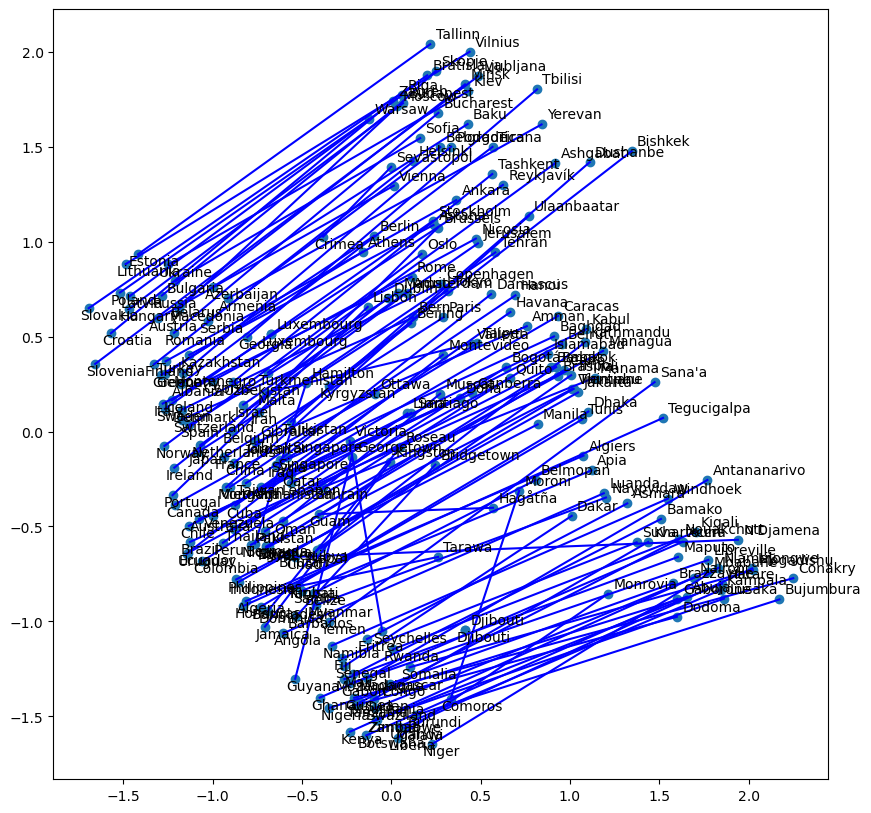

In [180]:
from sklearn.decomposition import PCA

#
# TODO
# use PCA from sklearn.decomposition to project the countries and capitals into 2D.
# draw lines connecting each country with its capital
#
# Hint:
# - the function "annotate" can be used to put text onto the plot
#
pca = PCA(n_components=2)
pca_comps = pca.fit_transform(geo_vecs)
X, Y = pca_comps.T
plt.figure(figsize=(10, 10))

plt.scatter(X, Y)
for i in tqdm(range(0, pca_comps.shape[0], 2)):
    plt.annotate(geo[i], xy=(X[i] - 5e-2, Y[i] - 6e-2))
    plt.annotate(geo[i+1], xy=(X[i+1] + 3e-2, Y[i+1] + 3e-2))
    plt.plot([X[i], X[i+1]],[Y[i], Y[i+1]], "blue")

plt.show()

## 5.4: PCA vs t-SNE on frequent words

In [176]:
# Select words starting from the 200th to ommit stop words,
# which have at least 3 chars
top_words = [w for (i,w) in enumerate(ftext.idx2word) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [ftext.word2idx[w] for w in top_words]
top_embed = ftext.vec[top_inds]

  0%|          | 0/400 [00:00<?, ?it/s]

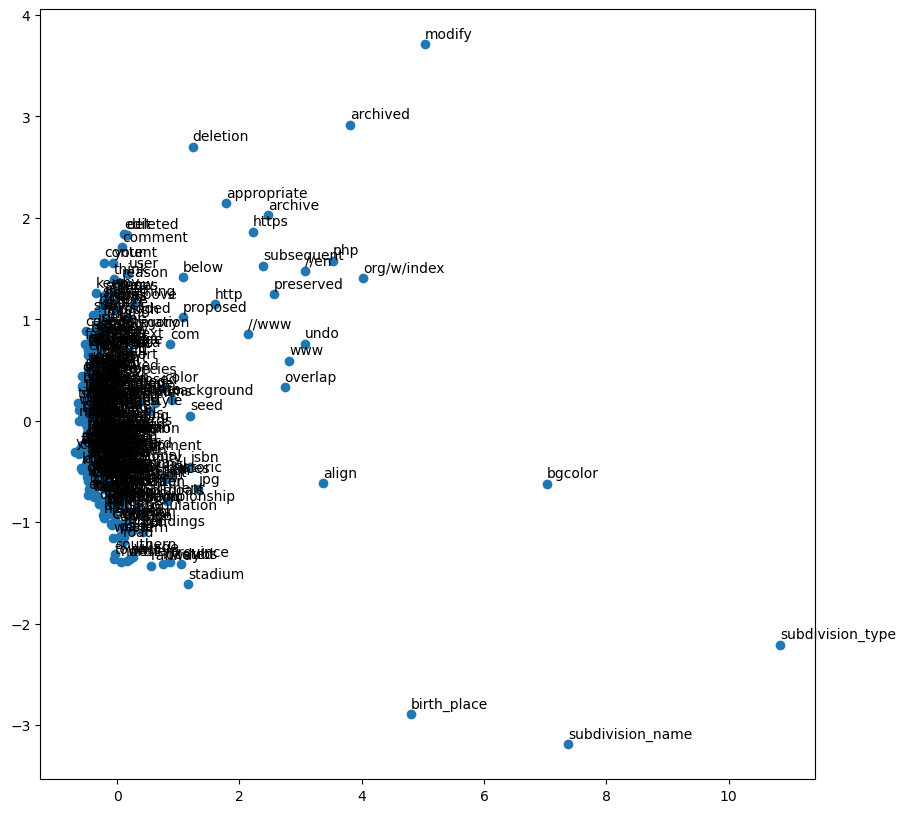

In [181]:
# TODO: make a 2D PCA projection of the selected words.
#
pca = PCA(n_components=2)
pca_comps = pca.fit_transform(top_embed)
X, Y = pca_comps.T
plt.figure(figsize=(10, 10))

plt.scatter(X, Y)
for i in tqdm(range(0, pca_comps.shape[0])):
    plt.annotate(top_words[i], xy=(X[i], Y[i] + 6e-2))

plt.show()


c:\Users\dmika\Anaconda3\envs\UniversityEnv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


  0%|          | 0/400 [00:00<?, ?it/s]

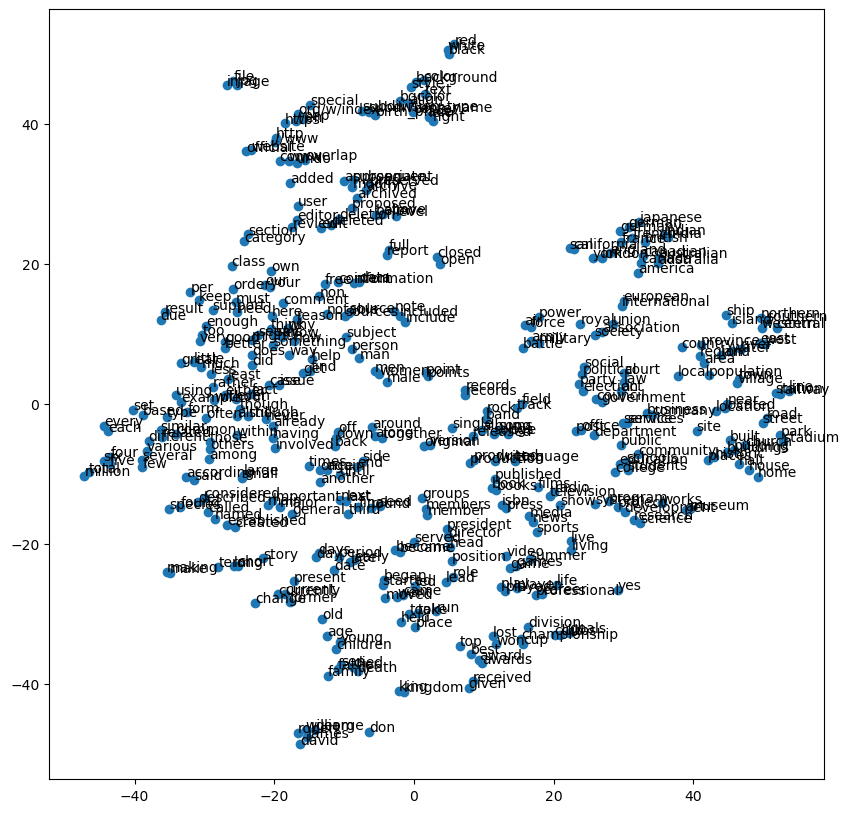

In [182]:
from sklearn.manifold import TSNE

#
# TODO: make a 2D t-SNE projection of the selected words.
# Things will cluster much nicer
#
tsne = TSNE(n_components=2, n_jobs=4, learning_rate=150, metric="cosine", perplexity=10)
tsne_comp = tsne.fit_transform(top_embed)
X, Y = tsne_comp.T
plt.figure(figsize=(10, 10))

plt.scatter(X, Y)
for i in tqdm(range(0, pca_comps.shape[0])):
    plt.annotate(top_words[i], xy=(X[i], Y[i] + 6e-2))

plt.show()